In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import io

In [5]:
qpcr_results = pd.read_excel("./20200331 Zymo Extraction.xlsx", sheet_name="Results", skiprows=42, na_values=['Undetermined'])

qpcr_results['Column'] = qpcr_results['Well Position'].str[1:].astype(np.int)
qpcr_results['Row'] = qpcr_results['Well Position'].str[:1]

# Standard Curve

In [19]:
# BPGX SC is at col 12, Thermo is at col 10
sc = qpcr_results[qpcr_results['Column'] == 12]

In [20]:
sc[['Sample Name', 'CT', 'Quantity', 'Amp Status']]

,Sample Name,CT,Quantity,Amp Status
11,PCD 1,17.490612,1.000000e+00,Inconclusive
23,PCD 2,20.971884,1.000000e-01,Amp
35,PCD 3,24.743444,1.000000e-02,Amp
47,PCD 4,29.139778,1.000000e-03,Amp
59,PCD 5,32.504460,1.000000e-04,Amp
71,PCD 6,35.269070,1.000000e-05,Amp
81,PCD 7,NaN,1.000000e-06,Inconclusive
91,PCD 8,NaN,1.000000e-07,No Amp


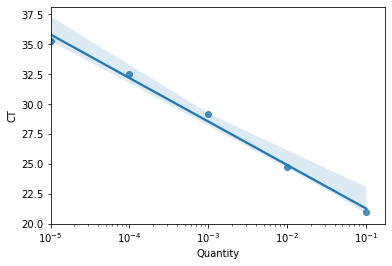

In [22]:
ax = sns.regplot(data=sc[sc['Amp Status'] == 'Amp'], x='Quantity', y='CT', logx=True)
ax.set_xscale('log')

# Negative Controls

In [24]:
negs = qpcr_results.loc[qpcr_results['Sample Name'].str.contains('Negative')]
negs[negs['Reporter'] == 'FAM']

,Well,Well Position,Omit,Sample Name,Target Name,Task,Reporter,Quencher,CT,Ct Mean,...,Baseline Start,Baseline End,Amp Status,Comments,AMPNC,EXPFAIL,CQCONF,HIGHSD,Column,Row
8,7,A7,False,Negative,FAM,NTC,FAM,NFQ-MGB,NaN,NaN,...,3,7,Inconclusive,NaN,N,N,N,N,7,A
20,19,B7,False,Negative,FAM,NTC,FAM,NFQ-MGB,NaN,NaN,...,3,25,No Amp,NaN,N,N,N,N,7,B
32,31,C7,False,Negative,FAM,NTC,FAM,NFQ-MGB,NaN,NaN,...,3,20,No Amp,NaN,N,N,N,N,7,C
44,43,D7,False,Negative,FAM,NTC,FAM,NFQ-MGB,NaN,NaN,...,3,17,No Amp,NaN,N,N,N,N,7,D
56,55,E7,False,Negative,FAM,NTC,FAM,NFQ-MGB,NaN,NaN,...,3,33,No Amp,NaN,N,N,N,N,7,E
68,67,F7,False,Negative,FAM,NTC,FAM,NFQ-MGB,22.699135,NaN,...,3,8,No Amp,NaN,Y,N,N,N,7,F


In [25]:
negs['Amp Status'].str.match('Amp').any()

False

# CoV

In [73]:
ncov = qpcr_results[(qpcr_results['Reporter'] == 'FAM') & qpcr_results['Sample Name'].str.contains('nCoV')]

In [74]:
ncov.loc[:, 'Sample Number'] = ncov['Sample Name'].str.replace(r'[\D]*([0-9]+)[\D]*', r'\1').astype(np.int)

/Users/anton/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/anton/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


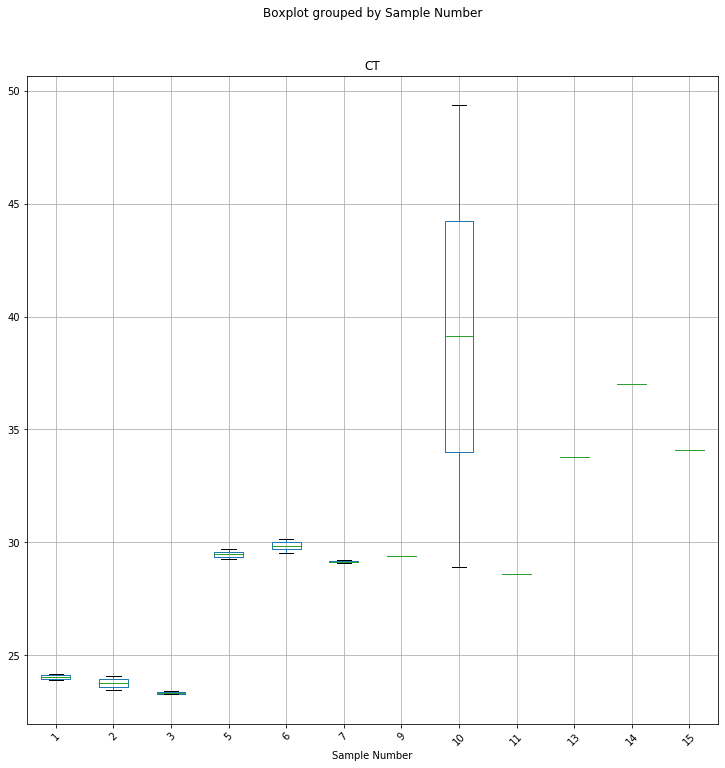

In [76]:
ncov[ncov['Amp Status'] == 'Amp'].boxplot(by='Sample Number', column='CT', rot=45, figsize=(12,12))

In [65]:
sample_data = '''
Sample Number	NP Sample	"Spike"
1		1000
2		1000
3		1000
4		0
5		20
6		20
7		20
8		0
9		1000
10		1000
11		1000
12		0
13		20
14		20
15		20
16		0
'''

sample_data = pd.read_table(io.StringIO(sample_data))

In [77]:
ncov = ncov.merge(sample_data)

## Yield

In [81]:
ncov.loc[ncov['Column'] == 1,'Extraction'] = 'Zymo-BPGX'
ncov.loc[ncov['Column'] == 4,'Extraction'] = 'Zymo-Thermo'

ncov.loc[ncov['Column'] == 2,'Extraction'] = 'Arcis-BPGX'
ncov.loc[ncov['Column'] == 5,'Extraction'] = 'Arcis-Thermo'

In [78]:
ncov['Quantity'] = ncov['Quantity'] * 1e6

In [98]:
zymo = ncov['Extraction'].str.contains('Zymo')
arcis = ncov['Extraction'].str.contains('Arcis')         

ncov.loc[zymo,'RNA Input'] = ncov.loc[zymo,'Spike'] * 400 / 30 * 5
ncov.loc[arcis,'RNA Input'] = ncov.loc[arcis,'Spike'] * 50 / 100 * 15 / 30 * 5

In [99]:
ncov.loc[:,'Yield'] = ncov['Quantity'] / ncov['RNA Input'] * 100

In [100]:
ncov.sort_values(by=['Extraction', 'Row'])[['Sample Name', 'Extraction', 'Yield', 'RNA Input', 'Quantity']]

,Sample Name,Extraction,Yield,RNA Input,Quantity
2,9 nCoV,Arcis-BPGX,NaN,1250.000000,NaN
6,10 nCoV,Arcis-BPGX,1.681497e-04,1250.000000,2.101872e-03
10,11 nCoV,Arcis-BPGX,1.050671e+04,1250.000000,1.313339e+05
14,12 nCoV,Arcis-BPGX,inf,0.000000,6.026728e+05
18,13 nCoV,Arcis-BPGX,NaN,25.000000,NaN
22,14 nCoV,Arcis-BPGX,NaN,25.000000,NaN
26,15 nCoV,Arcis-BPGX,NaN,25.000000,NaN
30,16 nCoV,Arcis-BPGX,inf,0.000000,4.957062e+07
3,9 nCoV,Arcis-Thermo,4.718793e+01,1250.000000,5.898491e+02
7,10 nCoV,Arcis-Thermo,6.451748e+01,1250.000000,8.064685e+02


In [103]:
ncov[(ncov['Spike'] > 0) & (ncov['Amp Status'] == 'Amp')].groupby('Extraction')['Yield'].describe()

,count,mean,std,min,25%,50%,75%,max
Extraction,,,,,,,,
Arcis-BPGX,1.0,0.000168,NaN,0.000168,0.000168,0.000168,0.000168,0.000168
Arcis-Thermo,6.0,80.227693,48.219831,19.826206,51.520315,70.861063,111.783272,149.320418
Zymo-BPGX,6.0,35.264824,9.136936,23.307689,29.722999,36.628458,37.764873,49.459480
Zymo-Thermo,6.0,39.259867,11.280486,24.631242,30.921601,40.646737,46.234613,53.857356


Arcis-BPGX           AxesSubplot(0.1,0.559091;0.363636x0.340909)
Arcis-Thermo    AxesSubplot(0.536364,0.559091;0.363636x0.340909)
Zymo-BPGX                AxesSubplot(0.1,0.15;0.363636x0.340909)
Zymo-Thermo         AxesSubplot(0.536364,0.15;0.363636x0.340909)
dtype: object

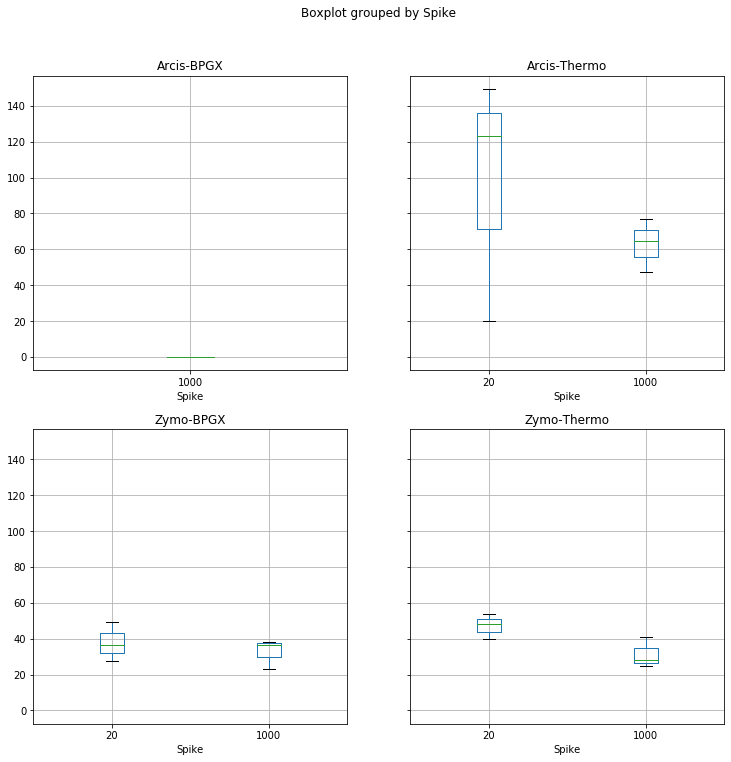

In [104]:
ncov[(ncov['Spike'] > 0) & (ncov['Amp Status'] == 'Amp')].groupby('Extraction').boxplot(by='Spike', column='Yield', figsize=(12,12))

## Diag

In [110]:
pos = qpcr_results[qpcr_results['Sample Name']=='PCD 1']
(pos['CT'] > 16).all()
(pos['CT'] < 23).all()

False

In [111]:
pos

,Well,Well Position,Omit,Sample Name,Target Name,Task,Reporter,Quencher,CT,Ct Mean,...,Baseline Start,Baseline End,Amp Status,Comments,AMPNC,EXPFAIL,CQCONF,HIGHSD,Column,Row
10,10,A10,False,PCD 1,FAM,STANDARD,FAM,NFQ-MGB,NaN,17.490612,...,3,4,No Amp,NaN,N,N,Y,N,10,A
11,12,A12,False,PCD 1,FAM,STANDARD,FAM,NFQ-MGB,17.490612,17.490612,...,3,12,Inconclusive,NaN,N,N,N,N,12,A


In [112]:
neg = qpcr_results[(qpcr_results['Sample Name']=='Negative') & (qpcr_results['Target Name'] == 'FAM')]
neg

,Well,Well Position,Omit,Sample Name,Target Name,Task,Reporter,Quencher,CT,Ct Mean,...,Baseline Start,Baseline End,Amp Status,Comments,AMPNC,EXPFAIL,CQCONF,HIGHSD,Column,Row
8,7,A7,False,Negative,FAM,NTC,FAM,NFQ-MGB,NaN,NaN,...,3,7,Inconclusive,NaN,N,N,N,N,7,A
20,19,B7,False,Negative,FAM,NTC,FAM,NFQ-MGB,NaN,NaN,...,3,25,No Amp,NaN,N,N,N,N,7,B
32,31,C7,False,Negative,FAM,NTC,FAM,NFQ-MGB,NaN,NaN,...,3,20,No Amp,NaN,N,N,N,N,7,C
44,43,D7,False,Negative,FAM,NTC,FAM,NFQ-MGB,NaN,NaN,...,3,17,No Amp,NaN,N,N,N,N,7,D
56,55,E7,False,Negative,FAM,NTC,FAM,NFQ-MGB,NaN,NaN,...,3,33,No Amp,NaN,N,N,N,N,7,E
68,67,F7,False,Negative,FAM,NTC,FAM,NFQ-MGB,22.699135,NaN,...,3,8,No Amp,NaN,Y,N,N,N,7,F


In [113]:
ierc = qpcr_results[(qpcr_results['Reporter'] == 'VIC') & qpcr_results['Sample Name'].str.contains('nCoV')]

In [117]:
ierc.sort_values(by=['Column','Row'])[['Sample Name','CT','Amp Status']]

,Sample Name,CT,Amp Status
1,1 nCoV,36.397606,Amp
13,2 nCoV,38.207970,Amp
25,3 nCoV,41.236780,Amp
37,4 nCoV,31.995209,Amp
49,5 nCoV,40.948963,Amp
61,6 nCoV,40.383450,Amp
73,7 nCoV,41.692696,Amp
83,8 nCoV,29.878645,Amp
3,9 nCoV,NaN,No Amp
15,10 nCoV,NaN,No Amp


In [118]:
ncov.sort_values(by='Sample Number')[['Sample Name','CT','Spike','Amp Status']]

,Sample Name,CT,Spike,Amp Status
0,1 nCoV,24.186981,1000,Amp
1,1 nCoV,23.902794,1000,Amp
4,2 nCoV,23.464098,1000,Amp
5,2 nCoV,24.099092,1000,Amp
8,3 nCoV,23.404310,1000,Amp
9,3 nCoV,23.280418,1000,Amp
13,4 nCoV,NaN,0,No Amp
12,4 nCoV,15.034176,0,Inconclusive
17,5 nCoV,29.265377,20,Amp
16,5 nCoV,29.696270,20,Amp


In [128]:
diags = list()
for i in range(1,9):
    name = "{} nCoV".format(i) 
    
    sample_data = qpcr_results[qpcr_results['Sample Name'] == '{} nCoV'.format(i)].set_index('Target Name')
    ierc = sample_data.loc['VIC'].iloc[0]
    ncov = sample_data.loc['FAM'].iloc[0]
    
    result = {
        'Sample Name': name, 
        'Well': ncov['Well'],
        'Result': 'Unknown', 
        'Type': 'Unknown', 
        'CT': ncov['CT'], 
        'Quantity': ncov['Quantity'],
        'IECRNA CT': ierc['CT']}
    
    if ncov['Amp Status'] == 'Amp':
        result['Result'] = 'Positive'
        if ncov['CT'] <= 30 or ierc['Amp Status'] == 'Amp':
            result['Type'] = 'Quantitative'
        elif ncov['CT'] > 30 and ierc['Amp Status'] == 'No Amp':
            result['Type'] = 'Qualitative'
    else:
        if ierc['Amp Status'] == 'Amp':
            result['Result'] = 'Negative'
            result['Type'] = 'Qualitative'
        else:
            result['Type'] = 'Sample Failure'
            
    diags.append(result)
            
diags = pd.DataFrame(diags)
diags

,Sample Name,Well,Result,Type,CT,Quantity,IECRNA CT
0,1 nCoV,1,Positive,Quantitative,24.186981,0.015538,36.397606
1,2 nCoV,13,Positive,Quantitative,23.464098,0.024474,38.207970
2,3 nCoV,25,Positive,Quantitative,23.404310,0.025411,41.236780
3,4 nCoV,37,Negative,Qualitative,15.034176,4.891526,31.995209
4,5 nCoV,49,Positive,Quantitative,29.696270,0.000487,40.948963
5,6 nCoV,61,Positive,Quantitative,30.151787,0.000366,40.383450
6,7 nCoV,73,Positive,Quantitative,29.214794,0.000659,41.692696
7,8 nCoV,85,Negative,Qualitative,25.435102,0.007092,29.878645


In [129]:
plate = diags.merge(qpcr_results.loc[qpcr_results['Target Name'] == 'FAM',['Sample Name', 'Well', 'Well Position']], on='Well')
plate['Column'] = plate['Well Position'].str[1:]
plate['Row'] = plate['Well Position'].str[:1]
plate = plate.pivot(index='Row', columns='Column', values='Result')
plate.to_clipboard()
plate

Column,1
Row,
A,Positive
B,Positive
C,Positive
D,Negative
E,Positive
F,Positive
G,Positive
H,Negative
